# Profiling

In [1]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from pandarallel import pandarallel
from nltk.corpus import stopwords
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud

In [2]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client.MAL
collection = db.anime_list

In [3]:
df = pd.DataFrame(list(collection.find({}, {"data.synopsis":1})))

for i in range(df.shape[0]):
    df.iloc[i]["data"] = df.iloc[i]["data"]["synopsis"]
    
df

,_id,data
0,655186867e442d2d9b63da4f,Megumi-chan is a girl with a secret past. She ...
1,655186867e442d2d9b63da50,"Just where do Curses, the fiendish spirits inv..."
2,655186867e442d2d9b63da51,"Years after the Fourth Holy Grail War, Waver V..."
3,655186867e442d2d9b63da52,Fudou Aikawa and Desumi Magahara have just sta...
4,655186867e442d2d9b63da53,"Having completed their Stagiaire assignments, ..."
...,...,...
4994,655186877e442d2d9b63edd2,"In the year 2314 AD, the world is at peace. Th..."
4995,655186877e442d2d9b63edd3,It is 2977 AD and mankind has become stagnant....
4996,655186877e442d2d9b63edd4,"After a fatal encounter with a truck, Takafumi..."
4997,655186877e442d2d9b63edd5,Haruhi Fujioka is a studious girl who has rece...


## Split Into Words

In [4]:
df["data_list"] = df["data"].str.split()
df = df.dropna()
df

,_id,data,data_list
0,655186867e442d2d9b63da4f,Megumi-chan is a girl with a secret past. She ...,"[Megumi-chan, is, a, girl, with, a, secret, pa..."
1,655186867e442d2d9b63da50,"Just where do Curses, the fiendish spirits inv...","[Just, where, do, Curses,, the, fiendish, spir..."
2,655186867e442d2d9b63da51,"Years after the Fourth Holy Grail War, Waver V...","[Years, after, the, Fourth, Holy, Grail, War,,..."
3,655186867e442d2d9b63da52,Fudou Aikawa and Desumi Magahara have just sta...,"[Fudou, Aikawa, and, Desumi, Magahara, have, j..."
4,655186867e442d2d9b63da53,"Having completed their Stagiaire assignments, ...","[Having, completed, their, Stagiaire, assignme..."
...,...,...,...
4994,655186877e442d2d9b63edd2,"In the year 2314 AD, the world is at peace. Th...","[In, the, year, 2314, AD,, the, world, is, at,..."
4995,655186877e442d2d9b63edd3,It is 2977 AD and mankind has become stagnant....,"[It, is, 2977, AD, and, mankind, has, become, ..."
4996,655186877e442d2d9b63edd4,"After a fatal encounter with a truck, Takafumi...","[After, a, fatal, encounter, with, a, truck,, ..."
4997,655186877e442d2d9b63edd5,Haruhi Fujioka is a studious girl who has rece...,"[Haruhi, Fujioka, is, a, studious, girl, who, ..."


## list of most common words

In [5]:
list_of_all_words = df["data_list"].to_list()
temp = []
for i in list_of_all_words:
    temp.extend(i)
list_of_all_words = temp

In [6]:
len(list_of_all_words)

539181

In [7]:
word_counts = Counter(list_of_all_words)
most_common_words = word_counts.most_common(10)
print("Top 10 most frequent words:")
for word, count in most_common_words:
    print(f"{word}: {count} times")

Top 10 most frequent words:
the: 32092 times
to: 17801 times
of: 15071 times
and: 14343 times
a: 14136 times
is: 7330 times
in: 7003 times
his: 6414 times
by: 5270 times
with: 4832 times


## Visualize Text

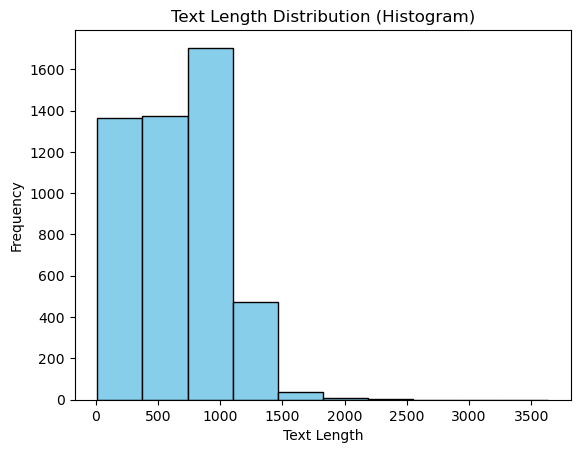

In [8]:
text_lengths = df['data'].apply(len)
plt.hist(text_lengths, color='skyblue', edgecolor='black')
plt.title('Text Length Distribution (Histogram)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

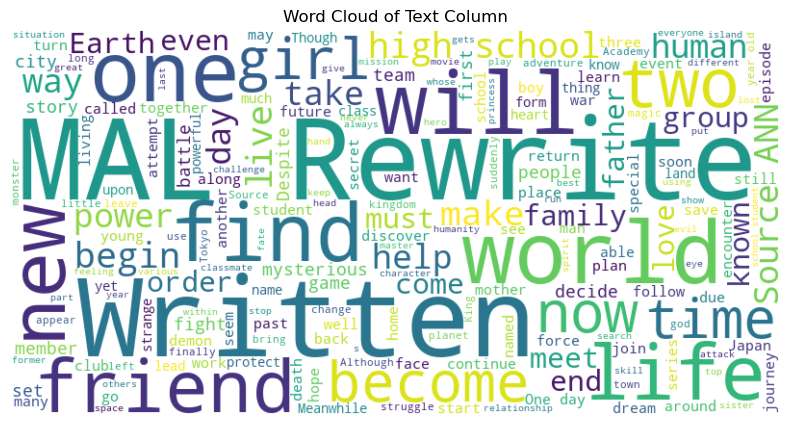

In [9]:
text = ' '.join(df['data'])
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=None).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Column')
plt.show()

## Number Of Stopwords

In [10]:
stop_words = set(stopwords.words('english'))
stop_words_count = df['data'].apply(lambda x: len([word for word in x.lower().split() if word in stop_words]))
print("Total number of stop words:", stop_words_count.sum())

Total number of stop words: 224369


## Check spelling mistakes and currect them

In [11]:
def check_spelling_mistakes(text):
    words = text.split()
    corrected_words = []

    for word in words:
        blob = TextBlob(word)
        corrected_word = str(blob.correct())
        corrected_words.append(corrected_word)

    corrected_text = ' '.join(corrected_words)
    return text != corrected_text

pandarallel.initialize(nb_workers=12)

results = df['data'].parallel_apply(check_spelling_mistakes)
df['spelling_mistakes'] = results
df.to_csv("new_data.csv", index=False)

df

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/tmp/ipykernel_62156/2515781542.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['spelling_mistakes'] = results


,_id,data,data_list,spelling_mistakes
0,655186867e442d2d9b63da4f,Megumi-chan is a girl with a secret past. She ...,"[Megumi-chan, is, a, girl, with, a, secret, pa...",True
1,655186867e442d2d9b63da50,"Just where do Curses, the fiendish spirits inv...","[Just, where, do, Curses,, the, fiendish, spir...",True
2,655186867e442d2d9b63da51,"Years after the Fourth Holy Grail War, Waver V...","[Years, after, the, Fourth, Holy, Grail, War,,...",True
3,655186867e442d2d9b63da52,Fudou Aikawa and Desumi Magahara have just sta...,"[Fudou, Aikawa, and, Desumi, Magahara, have, j...",True
4,655186867e442d2d9b63da53,"Having completed their Stagiaire assignments, ...","[Having, completed, their, Stagiaire, assignme...",True
...,...,...,...,...
4994,655186877e442d2d9b63edd2,"In the year 2314 AD, the world is at peace. Th...","[In, the, year, 2314, AD,, the, world, is, at,...",True
4995,655186877e442d2d9b63edd3,It is 2977 AD and mankind has become stagnant....,"[It, is, 2977, AD, and, mankind, has, become, ...",True
4996,655186877e442d2d9b63edd4,"After a fatal encounter with a truck, Takafumi...","[After, a, fatal, encounter, with, a, truck,, ...",True
4997,655186877e442d2d9b63edd5,Haruhi Fujioka is a studious girl who has rece...,"[Haruhi, Fujioka, is, a, studious, girl, who, ...",True


In [12]:
df["spelling_mistakes"].value_counts()

spelling_mistakes
True     4901
False      64
Name: count, dtype: int64